<div style="text-align: center"> 

## Data Analysis & Modeling
## Machine Learning
### Inma Jiménez

## Índice

1. [Preparación de los datos](#1.-Preparación-de-los-datos)


2. [Análisis de las variables](#2.-Análisis-de-las-variables)


3. [Machine Learning](#3.-Machine-Learning)

    3.1.[División en Train-Test](#3.1.-División-en-Train-Test)
       
    3.2. [Modelo de Regresión](#3.2.-Modelo-de-Regresión)
    
      3.2.1. [División en Train-Test sobre conjunto Train](#3.2.1.-División-en-Train-Test-sobre-conjunto-Train)
    
      3.2.2. [Modelo CatBoost](#3.2.2.-Modelo-CatBoost)
      
      3.2.3. [Modelo de Regresión Lineal](#3.2.3.-Modelo-de-Regresión-Lineal)
      
      3.2.4. [Modelo GradientBoostingRegressor](#3.2.4.-Modelo-GradientBoostingRegressor)
      
    3.4. [Se guarda el modelo](#3.4.-Se-guarda-el-modelo)
    

4.  [Hiperparametrización](#4.-Hiperparametrización)

    4.1. [RandomSearch](#4.1.-RandomSearch)
    
    4.2. [GridSearch. Modelo Definitivo](#4.2.-GridSearch.-Modelo-Definitivo)
    
    4.3. [Se guarda el modelo](#4.3.-Se-guarda-el-modelo)
    
    
5. [Conclusión](#3.-Conclusión)

#### Librerías

In [222]:
from catboost import CatBoostRegressor, Pool

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd
import pickle

import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

#### Funciones

In [223]:
'''
Función que permite sustituir valores nulos de una columna específica.

Acoge los siguientes argumentos:

    - 'df', refiere al DataFrame sobre el que se quiere trabajar.
    
    - 'column_name' es la columna sobre la que se va a sustituir el valor nulo.
    
    - 'row_name' es la fila sobre la que se quiere sustituir el valor nulo.
    
    - 'value_1' indica el valor de la celda que ha de buscar la función para identificar la fila sobre la que 
    se quiere sustituir el valor nulo.
    
    - 'value_2' es el valor por el que se quiere sustituir el valor nulo.
    
'''
## Entrenamiento del modelo

def sustitution(df, column_name, row_name, value_1, value_2):
    
    for index, row in (df.loc[df[column_name].isnull()]).iterrows():
    
        if row[row_name] == value_1:
            df[column_name][index] = value_2
            
    
    return df

In [224]:
'''
Esta función permite extraer un resumen de información sobre el conuntos de datos del DataSet sobre el que se está
trabajando.

El argumento que se requiere es el siguiente:


        - 'df' que refiere al DataFrame sobre el que se quiere trabajar.

'''

def data_report(df):

    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T

In [225]:
'''
Esta función permite visualizar un histograma con las 'features importance' de cada una de las variables incluidas
en la 'X' que se ha definido anteriormente.

Los argumentos a incluir son los siguientes:

    - 'features' se refiere al nombre de las columnas del DataFrame.
    Se incluye la variable que contiene el conjunto train + '.columns' para obtener el nombre de 
    cada una de las features. Ej. 'X.columns'
    
    - 'model_importances' es la variable sobre la que se ejecuta el modelo elegido y  sobre la que se ejecutará
    la función 'feature_importances_'.
    Se incluye la variable que contiene el modelo a ejecutar + '.feature_importances_'. 
    Ej. 'importance_feature.feature_importances_'
    
'''


def plot_feature_importance(features, model_importances):

    indices = np.argsort(model_importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), model_importances[indices], color='y', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

### 1. Preparación de los datos

Se importa el csv creado - *data_nba.csv* - con los datos de la API de la NBA extaidos, preparados y limpiados anteriormente

In [226]:
pd.options.display.max_columns = None

data_nba_2 = pd.read_csv('/home/inma/Escritorio/The Bridge/Data_Science_Curso/Clase/Repository_Inma/ML/ML_NBA_Inma Jimenez/scr/data/processed_files/data_nba_processed.csv')
data_nba_2

,temporada,anio,id_jugador,nombre_jugador,draft_anio,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,posicion_juego,pir_medio_total,anios_experiencia
0,2011-2012,2011.0,201142,Kevin Durant,2007,2.06,106.6,1,Oklahoma City,Thunder,Western,66,3.5,1.1,27.288,19.652,9.742,49.6,7.591,2.015,86.0,5.212,2.015,38.7,28.0,38.6,7.4,0.6,8.0,2.0,1.3,3.7,231,77,27.288,1297,643,49.6,501,431,86.0,344,133,38.7,2546,1850,487,40,527,248,88,133,6.0,Alero,21.98,4.0
1,2011-2012,2011.0,977,Kobe Bryant,1996,1.98,93.0,2,Los Angeles,Lakers,Western,58,4.6,0.3,21.448,23.034,9.897,43.0,7.776,1.500,84.5,4.948,1.500,30.3,27.9,38.5,4.3,1.1,5.4,1.8,1.1,3.5,264,18,21.448,1336,574,43.0,451,381,84.5,287,87,30.3,2232,1616,247,66,313,204,69,105,10.0,Base,16.02,15.0
2,2011-2012,2011.0,2544,LeBron James,2003,2.03,113.4,3,Miami,Heat,Eastern,62,6.2,0.8,29.855,18.855,10.016,53.1,8.097,0.871,77.1,2.403,0.871,36.2,27.1,37.5,6.4,1.5,7.9,1.5,1.8,3.4,387,50,29.855,1169,621,53.1,502,387,77.1,149,54,36.2,2326,1683,398,94,492,213,115,96,3.0,Alero,26.73,8.0
3,2011-2012,2011.0,201567,Kevin Love,2008,2.08,117.9,4,Minnesota,Timberwolves,Western,55,2.0,0.5,28.327,19.255,8.618,44.8,8.364,1.909,82.4,5.127,1.909,37.2,26.0,39.0,9.2,4.1,13.3,2.8,0.8,2.3,111,28,28.327,1059,474,44.8,460,379,82.4,282,105,37.2,2145,1432,508,226,734,128,47,152,4.0,Ala-Pivot,22.27,3.0
4,2011-2012,2011.0,201566,Russell Westbrook,2008,1.91,84.8,5,Oklahoma City,Thunder,Western,66,5.5,0.3,20.515,19.182,8.758,45.7,6.258,0.939,82.3,2.970,0.939,31.6,23.6,35.3,3.1,1.5,4.6,2.2,1.7,3.6,362,21,20.515,1266,578,45.7,413,340,82.3,196,62,31.6,2331,1558,205,96,301,239,112,147,11.0,Base,16.09,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5365,2022-2023,2022.0,1631098,Johnny Davis,2022,1.93,88.5,458,Washington,Wizards,Eastern,13,0.2,0.1,1.100,1.385,0.462,33.3,0.231,0.077,100.0,0.308,0.077,25.0,1.2,4.8,0.5,0.1,0.6,1.0,0.1,0.2,2,1,1.100,18,6,33.3,3,3,100.0,4,1,25.0,62,16,7,1,8,2,1,13,0.0,Base,-0.15,0.0
5366,2022-2023,2022.0,1627853,Ryan Arcidiacono,2016,1.90,88.5,463,Portland,Trail Blazers,Western,14,0.6,0.0,1.400,1.000,0.286,28.6,0.000,0.286,0.0,0.643,0.286,44.4,0.9,5.0,0.7,0.0,0.7,0.4,0.1,0.2,8,0,1.400,14,4,28.6,0,0,0.0,9,4,44.4,70,12,10,0,10,3,2,6,0.0,Base,0.57,6.0
5367,2022-2023,2022.0,1630556,Kessler Edwards,2021,2.01,92.1,464,Sacramento,Kings,Western,16,0.3,0.1,0.800,1.750,0.375,21.4,0.125,0.125,50.0,0.875,0.125,14.3,0.9,5.9,0.6,0.4,1.0,0.2,0.2,0.3,4,1,0.800,28,6,21.4,2,1,50.0,14,2,14.3,94,15,9,7,16,4,3,3,0.0,Alero,-0.19,1.0
5368,2022-2023,2022.0,1631246,Vince Williams Jr.,2022,1.93,93.0,468,Memphis,Grizzlies,Western,10,0.3,0.1,1.100,1.300,0.300,23.1,0.000,0.100,0.0,0.900,0.100,11.1,0.7,4.9,0.5,0.2,0.7,0.6,0.4,0.1,3,1,1.100,13,3,23.1,0,0,0.0,9,1,11.1,49,7,5,2,7,1,4,6,0.0,Base,-0.30,0.0


In [227]:
# El DataSet cuenta con 5839 filas y 54 columnas

data_nba_2.shape

(5370, 56)

In [228]:
# Se vuelve a comprobar si hay valores nulos

data_nba_2.isnull().sum()

temporada                0
anio                     0
id_jugador               0
nombre_jugador           0
draft_anio               0
altura                   0
peso_kg                  0
num_ranking              0
ciudad_equipo            0
nombre_equipo            0
conferencia              0
partidos_jugados         0
asistencias_pp           0
tapones_pp               0
eficiencia_tiro_pp       0
tci_pp                   0
tce_pp                   0
porcentaje_tc_pp         0
tli_pp                   0
tle_pp                   0
porcentaje_tl_pp         0
tti_pp                   0
tte_pp                   0
porcentaje_tt_pp         0
puntos_pp                0
minutos_pp               0
reb_def_pp               0
reb_of_pp                0
total_rebotes_pp         0
faltas_pp                0
robos_pp                 0
perdidas_pp              0
asistencias_total        0
tapones_total            0
eficiencia_tiro_total    0
tci_total                0
tce_total                0
p

In [190]:
'''
Se crea un DataSet ('df_nba') sin la temporada 2022-2023. Ya que es la temporada que está sucendiendo actualmente y 
cada semana los datos se modifican con los nuevos estadísticos de los jugadores.

Este será el DataSet que se usará en el análisis posterior y para la definición de modelos de Machine Learning.

'''

df_nba_2 = data_nba_2.loc[(data_nba_2['temporada'] != '2022-2023')]
df_nba_2

,temporada,anio,id_jugador,nombre_jugador,draft_anio,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,posicion_juego,pir_medio_total,anios_experiencia
0,2011-2012,2011.0,201142,Kevin Durant,2007,2.06,106.6,1,Oklahoma City,Thunder,Western,66,3.5,1.1,27.288,19.652,9.742,49.6,7.591,2.015,86.0,5.212,2.015,38.7,28.0,38.6,7.4,0.6,8.0,2.0,1.3,3.7,231,77,27.288,1297,643,49.6,501,431,86.0,344,133,38.7,2546,1850,487,40,527,248,88,133,6.0,Alero,21.98,4.0
1,2011-2012,2011.0,977,Kobe Bryant,1996,1.98,93.0,2,Los Angeles,Lakers,Western,58,4.6,0.3,21.448,23.034,9.897,43.0,7.776,1.500,84.5,4.948,1.500,30.3,27.9,38.5,4.3,1.1,5.4,1.8,1.1,3.5,264,18,21.448,1336,574,43.0,451,381,84.5,287,87,30.3,2232,1616,247,66,313,204,69,105,10.0,Base,16.02,15.0
2,2011-2012,2011.0,2544,LeBron James,2003,2.03,113.4,3,Miami,Heat,Eastern,62,6.2,0.8,29.855,18.855,10.016,53.1,8.097,0.871,77.1,2.403,0.871,36.2,27.1,37.5,6.4,1.5,7.9,1.5,1.8,3.4,387,50,29.855,1169,621,53.1,502,387,77.1,149,54,36.2,2326,1683,398,94,492,213,115,96,3.0,Alero,26.73,8.0
3,2011-2012,2011.0,201567,Kevin Love,2008,2.08,117.9,4,Minnesota,Timberwolves,Western,55,2.0,0.5,28.327,19.255,8.618,44.8,8.364,1.909,82.4,5.127,1.909,37.2,26.0,39.0,9.2,4.1,13.3,2.8,0.8,2.3,111,28,28.327,1059,474,44.8,460,379,82.4,282,105,37.2,2145,1432,508,226,734,128,47,152,4.0,Ala-Pivot,22.27,3.0
4,2011-2012,2011.0,201566,Russell Westbrook,2008,1.91,84.8,5,Oklahoma City,Thunder,Western,66,5.5,0.3,20.515,19.182,8.758,45.7,6.258,0.939,82.3,2.970,0.939,31.6,23.6,35.3,3.1,1.5,4.6,2.2,1.7,3.6,362,21,20.515,1266,578,45.7,413,340,82.3,196,62,31.6,2331,1558,205,96,301,239,112,147,11.0,Base,16.09,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4924,2021-2022,2021.0,1630612,RJ Nembhard Jr.,2021,1.93,90.7,477,Cleveland,Cavaliers,Eastern,14,0.9,0.0,1.400,1.286,0.429,33.3,0.286,0.000,75.0,0.143,0.000,0.0,1.1,4.5,0.3,0.2,0.5,0.1,0.1,0.2,12,0,1.400,18,6,33.3,4,3,75.0,2,0,0.0,63,15,4,3,7,3,1,2,0.0,Base,1.07,0.0
4925,2021-2022,2021.0,1630582,Yves Pons,2021,1.96,93.4,478,Memphis,Grizzlies,Western,12,0.1,0.3,1.400,1.333,0.417,31.3,0.167,0.250,0.0,0.750,0.250,33.3,1.1,5.9,0.6,0.4,1.0,0.5,0.1,0.1,1,4,1.400,16,5,31.3,2,0,0.0,9,3,33.3,71,13,7,5,12,1,1,6,0.0,Alero,0.42,0.0
4926,2021-2022,2021.0,1630539,Kai Jones,2021,2.08,100.2,479,Charlotte,Hornets,Eastern,21,0.2,0.1,1.100,0.667,0.429,64.3,0.381,0.048,37.5,0.095,0.048,50.0,1.0,3.0,0.4,0.1,0.5,0.4,0.0,0.3,4,2,1.100,14,9,64.3,8,3,37.5,2,1,50.0,63,22,8,3,11,6,1,8,0.0,Ala-Pivot,0.71,0.0
4927,2021-2022,2021.0,202334,Ed Davis,2010,2.06,98.9,483,Cleveland,Cavaliers,Eastern,31,0.2,0.3,3.000,0.516,0.355,68.8,0.452,0.000,42.9,0.000,0.000,0.0,0.9,6.5,1.6,0.5,2.1,1.1,0.1,0.2,7,9,3.000,16,11,68.8,14,6,42.9,0,0,0.0,201,28,50,14,64,5,3,33,0.0,Ala-Pivot,1.94,11.0


## 2. Análisis de las variables

In [191]:
# Se observa el 'dtype' de cada variable

df_nba_2.dtypes

temporada                 object
anio                     float64
id_jugador                 int64
nombre_jugador            object
draft_anio                 int64
altura                   float64
peso_kg                  float64
num_ranking                int64
ciudad_equipo             object
nombre_equipo             object
conferencia               object
partidos_jugados           int64
asistencias_pp           float64
tapones_pp               float64
eficiencia_tiro_pp       float64
tci_pp                   float64
tce_pp                   float64
porcentaje_tc_pp         float64
tli_pp                   float64
tle_pp                   float64
porcentaje_tl_pp         float64
tti_pp                   float64
tte_pp                   float64
porcentaje_tt_pp         float64
puntos_pp                float64
minutos_pp               float64
reb_def_pp               float64
reb_of_pp                float64
total_rebotes_pp         float64
faltas_pp                float64
robos_pp  

In [192]:
corr_df = df_nba_2.corr()
corr_df.style.background_gradient(cmap = 'coolwarm')

,anio,id_jugador,draft_anio,altura,peso_kg,num_ranking,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,pir_medio_total,anios_experiencia
anio,1.000000,0.602317,0.063629,-0.084426,-0.089334,0.055510,-0.082910,0.051261,0.021730,0.089455,0.029599,0.044356,0.082350,-0.019945,0.183872,0.073820,0.188513,0.183872,0.176335,0.071796,-0.012835,0.054934,-0.050074,0.024092,-0.018936,0.023250,-0.021081,0.013162,-0.042439,0.089455,-0.009282,0.003202,0.082350,-0.045575,-0.033170,0.073820,0.169980,0.162992,0.176335,-0.059439,0.015449,0.000979,-0.073847,-0.021767,-0.064663,-0.053345,-0.064174,-0.019722,0.044134,-0.055359
id_jugador,0.602317,1.000000,0.032930,-0.064408,-0.123747,0.210790,-0.200961,-0.109957,-0.053198,-0.130832,-0.110487,-0.112028,-0.002624,-0.115901,-0.002764,-0.054174,0.011316,-0.002764,0.067701,-0.121154,-0.187403,-0.126066,-0.096009,-0.123985,-0.130826,-0.104664,-0.151839,-0.136940,-0.112041,-0.130832,-0.166402,-0.161728,-0.002624,-0.168560,-0.164377,-0.054174,-0.034691,-0.042135,0.067701,-0.211753,-0.158068,-0.165946,-0.138954,-0.165092,-0.186068,-0.169617,-0.183088,-0.148663,-0.142233,-0.544499
draft_anio,0.063629,0.032930,1.000000,0.002174,0.004501,-0.070857,0.076586,0.050412,0.016718,0.066893,0.056769,0.059399,0.020263,0.029019,0.055966,0.032670,0.052512,0.055966,0.065892,0.068032,0.071061,0.056311,0.006178,0.043382,0.052036,0.060754,0.059830,0.057429,0.036414,0.066893,0.074848,0.073861,0.020263,0.049404,0.050248,0.032670,0.065665,0.064259,0.065892,0.078658,0.072457,0.064323,0.029692,0.056631,0.067382,0.065869,0.071174,0.040978,0.054450,0.080626
altura,-0.084426,-0.064408,0.002174,1.000000,0.804683,0.067589,0.016476,-0.434632,0.514834,0.093146,-0.121115,-0.038565,0.425251,0.017171,-0.307742,-0.251624,-0.313985,-0.307742,-0.364411,-0.073269,-0.087375,0.391286,0.545687,0.467015,0.232765,-0.252927,-0.162856,-0.354933,0.453954,0.093146,-0.086303,-0.011614,0.425251,0.042226,-0.009425,-0.251624,-0.306172,-0.295305,-0.364411,-0.039211,-0.047113,0.315607,0.461026,0.373907,-0.112373,-0.180457,0.163393,0.048708,0.170733,0.036490
peso_kg,-0.089334,-0.123747,0.004501,0.804683,1.000000,0.016401,0.030406,-0.346511,0.467588,0.150301,-0.073698,0.011780,0.426657,0.062672,-0.295249,-0.228883,-0.301921,-0.295249,-0.377886,-0.015795,-0.042229,0.418845,0.579054,0.498053,0.270349,-0.205280,-0.086175,-0.281056,0.419881,0.150301,-0.043109,0.032719,0.426657,0.090804,0.036574,-0.228883,-0.296086,-0.285146,-0.377886,-0.009803,-0.003754,0.340901,0.492764,0.402287,-0.051393,-0.142223,0.190331,0.131284,0.227564,0.135756
num_ranking,0.055510,0.210790,-0.070857,0.067589,0.016401,1.000000,-0.540798,-0.614502,-0.303469,-0.866150,-0.759650,-0.798758,-0.212193,-0.592606,-0.481322,-0.367299,-0.462912,-0.481322,-0.262004,-0.927819,-0.921063,-0.650401,-0.330711,-0.586585,-0.616779,-0.645979,-0.775749,-0.634121,-0.374381,-0.866150,-0.869715,-0.867386,-0.212193,-0.753367,-0.757260,-0.367299,-0.603257,-0.590895,-0.262004,-0.811854,-0.866404,-0.656977,-0.403459,-0.608928,-0.771894,-0.667927,-0.646733,-0.455907,-0.781006,-0.185218
partidos_jugados,-0.082910,-0.200961,0.076586,0.016476,0.030406,-0.540798,1.000000,0.289175,0.222496,0.476490,0.359702,0.394660,0.220916,0.265755,0.248310,0.233086,0.223582,0.248310,0.163236,0.439471,0.561406,0.404289,0.256686,0.381661,0.433122,0.378988,0.347806,0.512594,0.450405,0.476490,0.701058,0.697003,0.220916,0.551855,0.534098,0.233086,0.509689,0.494358,0.163236,0.851493,0.682695,0.670984,0.503058,0.649625,0.640571,0.681804,0.829342,0.35721

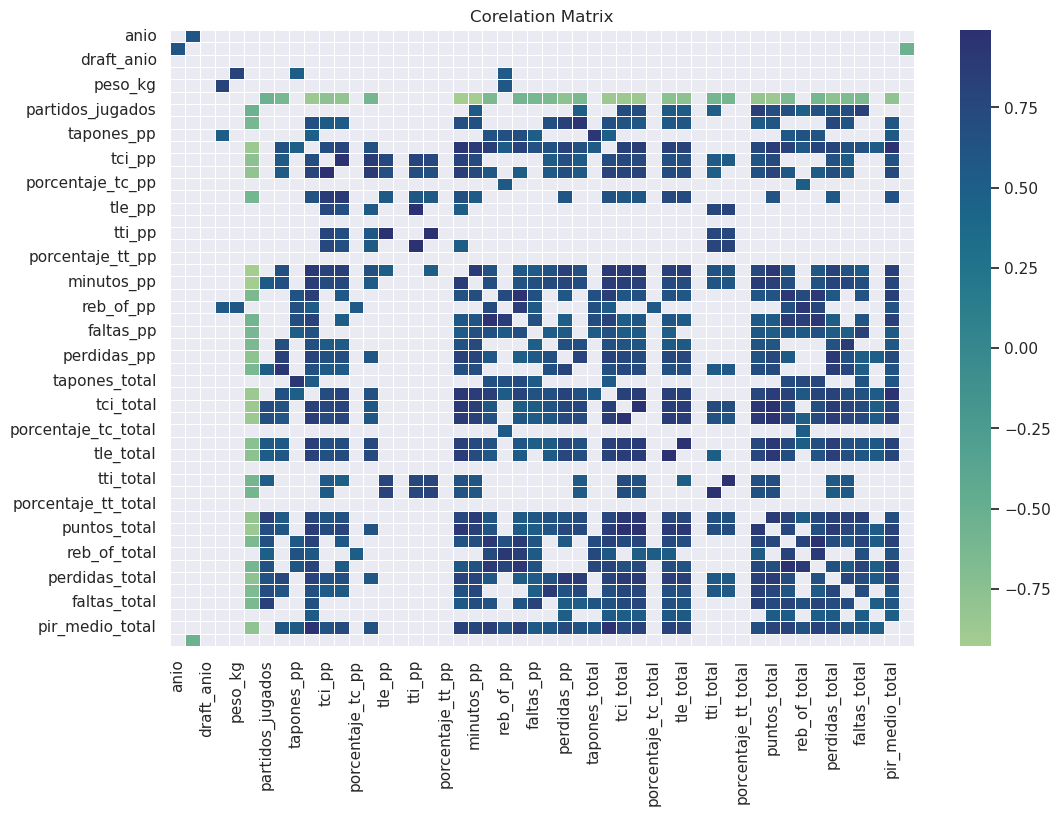

In [193]:
# Se visualiza la correlación entre las features siempre que sea mayor a 0.5

sns.set(rc={'figure.figsize':(12,8)})

corr = df_nba_2.corr()

sns.heatmap(corr[((corr >= 0.5) | (corr <= -0.5)) & (corr != 1)], 
            annot=False, 
            cmap = 'crest',
            linewidths=.5, 
            fmt= '.2f')

plt.title('Corelation Matrix');

__________________________________________________________________________________________________________________

## 3. Machine Learning

### 3.1. División en Train-Test

In [194]:
# Se divide el DataSet en train ('df_train') y test ('df_test')

df_train, df_test = train_test_split(df_nba_2, 
                                     test_size = 0.2,
                                     random_state = 0)

In [195]:
df_train.shape

(3943, 56)

In [196]:
df_test.shape

(986, 56)

In [197]:
# Se aparta el conjunto de Test y se echa un vistazo al Train

data_report(df_train)

COL_N,temporada,anio,id_jugador,nombre_jugador,draft_anio,altura,peso_kg,num_ranking,ciudad_equipo,nombre_equipo,conferencia,partidos_jugados,asistencias_pp,tapones_pp,eficiencia_tiro_pp,tci_pp,tce_pp,porcentaje_tc_pp,tli_pp,tle_pp,porcentaje_tl_pp,tti_pp,tte_pp,porcentaje_tt_pp,puntos_pp,minutos_pp,reb_def_pp,reb_of_pp,total_rebotes_pp,faltas_pp,robos_pp,perdidas_pp,asistencias_total,tapones_total,eficiencia_tiro_total,tci_total,tce_total,porcentaje_tc_total,tli_total,tle_total,porcentaje_tl_total,tti_total,tte_total,porcentaje_tt_total,minutos_total,puntos_total,reb_def_total,reb_of_total,rebotes_total,perdidas_total,robos_total,faltas_total,faltas_tecnicas_total,posicion_juego,pir_medio_total,anios_experiencia
DATA_TYPE,object,float64,int64,object,int64,float64,float64,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,object,float64,float64
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,11,11,1183,1181,29,23,121,504,31,31,2,82,103,32,623,3123,2611,431,2224,1564,497,2349,1564,343,290,354,108,52,143,41,26,50,515,168,623,1166,641,431,494,409,497,540,249,343,2096,1360,565,274,707,280,164,270,20,6,1577,22
CARDIN (%),0.28,0.28,30.0,29.95,0.74,0.58,3.07,12.78,0.79,0.79,0.05,2.08,2.61,0.81,15.8,79.2,66.22,10.93,56.4,39.67,12.6,59.57,39.67,8.7,7.35,8.98,2.74,1.32,3.63,1.04,0.66,1.27,13.06,4.26,15.8,29.57,16.26,10.93,12.53,10.37,12.6,13.7,6.31,8.7,53.16,34.49,14.33,6.95,17.93,7.1,4.16,6.85,0.51,0.15,39.99,0.56


__________________________________________________________________________________________________________________

### 3.2. Modelo de Regresión

Se quiere crear un modelo de Regresión para predecir el PIR medio de los jugadores en base a sus estadísticos.

### 3.2.1. División en Train-Test sobre conjunto Train

In [198]:
'''
Se pretende predecir el PIR de los jugadores. El PIR es una medida calculada a través de otras features de este
DataSet, por ello se eliminan las features utilizadas para conformarla y aquellas que correlacionen altamente
con las variables a través de las que se calcula el PIR medio.
Posteriormente se observa la correlación entre el PIR medio de los jugadores y el resto de las features.

'''

df_train_copy = df_train.copy()

In [199]:
df_train_copy.drop(columns = ['asistencias_total', 'tapones_total', 'tce_total', 'tle_total', 'tte_total',
                              'puntos_total', 'rebotes_total', 'robos_total', 'tci_total', 'tli_total', 
                              'tti_total', 'perdidas_total', 'faltas_total', 'faltas_tecnicas_total', 
                              'partidos_jugados', 'asistencias_pp', 'tapones_pp', 'eficiencia_tiro_pp', 'tci_pp',
                              'tce_pp', 'porcentaje_tc_pp', 'tli_pp', 'tle_pp', 'porcentaje_tl_pp', 'tti_pp', 
                              'tte_pp', 'porcentaje_tt_pp', 'puntos_pp', 'reb_def_pp', 'reb_of_pp', 
                              'total_rebotes_pp', 'faltas_pp', 'robos_pp', 'perdidas_pp', 'eficiencia_tiro_total',
                              'porcentaje_tc_total', 'porcentaje_tl_total', 'porcentaje_tt_total', 
                              'reb_def_total', 'reb_of_total'],
                   inplace = True)

In [200]:
# Se comprueba la correlación entre las variables del conjunto Train

corr_df = df_train_copy.corr()
corr_df.style.background_gradient(cmap = 'PuBu')

,anio,id_jugador,draft_anio,altura,peso_kg,num_ranking,minutos_pp,minutos_total,pir_medio_total,anios_experiencia
anio,1.000000,0.601412,0.068534,-0.080765,-0.097126,0.045623,-0.002116,-0.050493,0.048809,-0.064420
id_jugador,0.601412,1.000000,0.031585,-0.062909,-0.129554,0.217256,-0.192029,-0.216445,-0.146980,-0.553470
draft_anio,0.068534,0.031585,1.000000,0.007366,0.010462,-0.062580,0.065352,0.078463,0.052372,0.075711
altura,-0.080765,-0.062909,0.007366,1.000000,0.801804,0.059000,-0.083685,-0.036673,0.172631,0.037317
peso_kg,-0.097126,-0.129554,0.010462,0.801804,1.000000,0.007595,-0.039653,-0.007425,0.230086,0.142467
num_ranking,0.045623,0.217256,-0.062580,0.059000,0.007595,1.000000,-0.920958,-0.814319,-0.782897,-0.194066
minutos_pp,-0.002116,-0.192029,0.065352,-0.083685,-0.039653,-0.920958,1.000000,0.874195,0.768343,0.210756
minutos_total,-0.050493,-0.216445,0.078463,-0.036673,-0.007425,-0.814319,0.874195,1.000000,0.694588,0.186668
pir_medio_total,0.048809,-0.146980,0.052372,0.172631,0.230086,-0.782897,0.768343,0.694588,1.000000,0.197224
anios_experiencia,-0.064420,-0.553470,0.075711,0.037317,0.142467,-0.194066,0.210756,0.186668,0.197224,1.000000


In [201]:
# Se analiza la correlación de las features con la variables target ('pir_medio_total')

pir_corr = abs(corr_df["pir_medio_total"])
pir_corr.sort_values(ascending = False)

pir_medio_total      1.000000
num_ranking          0.782897
minutos_pp           0.768343
minutos_total        0.694588
peso_kg              0.230086
anios_experiencia    0.197224
altura               0.172631
id_jugador           0.146980
draft_anio           0.052372
anio                 0.048809
Name: pir_medio_total, dtype: float64

In [202]:
# La correlación entre algunas features es muy alta entre ellas
# Se eliminan aquellas que tienen menos correlación con el target ('pir_medio_total') y las que tienen una correlación por debajo de 0.5 con el target

df_train_copy.drop(columns = ['minutos_total', 'altura', 'peso_kg', 'id_jugador', 'draft_anio', 'anio'],
                   inplace = True)

In [203]:
# Se comprueba de nuevo la correlación entre las features y el target

corr_df = df_train_copy.corr()
pir_corr = abs(corr_df["pir_medio_total"])
pir_corr.sort_values(ascending = False)

pir_medio_total      1.000000
num_ranking          0.782897
minutos_pp           0.768343
anios_experiencia    0.197224
Name: pir_medio_total, dtype: float64

In [204]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 3785 to 2732
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temporada          3943 non-null   object 
 1   nombre_jugador     3943 non-null   object 
 2   num_ranking        3943 non-null   int64  
 3   ciudad_equipo      3943 non-null   object 
 4   nombre_equipo      3943 non-null   object 
 5   conferencia        3943 non-null   object 
 6   minutos_pp         3943 non-null   float64
 7   posicion_juego     3943 non-null   object 
 8   pir_medio_total    3943 non-null   float64
 9   anios_experiencia  3943 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 338.9+ KB


__________________________________________________________________________________________________________________

### 3.2.2. Modelo CatBoost

In [205]:
# Se divide de nuevo el conjunto Train

X_1 = df_train_copy.drop(columns = ["pir_medio_total"])


y_1 = df_train_copy["pir_medio_total"]

In [206]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1,
                                                            y_1,
                                                            test_size = 0.2,
                                                            random_state = 24)

In [208]:
# Se crea el modelo del CatBoost

model_catboost_1 = CatBoostRegressor(n_estimators = 200,
                                   loss_function = 'MAE',
                                   random_state = 42)

# Se crea el Pool, dónde se indican las variables categóricas

pool_train_1 = Pool(X_train_1, y_train_1,
                    cat_features=['temporada','nombre_jugador','posicion_juego',
                                  'ciudad_equipo','nombre_equipo', 'conferencia'])

In [209]:
# Se entrena el modelo

model_catboost_1.fit(pool_train_1)

0:	learn: 4.0220098	total: 3.93ms	remaining: 782ms
1:	learn: 3.9407789	total: 7.19ms	remaining: 712ms
2:	learn: 3.8578907	total: 10ms	remaining: 657ms
3:	learn: 3.7861358	total: 12.6ms	remaining: 617ms
4:	learn: 3.7092732	total: 14.6ms	remaining: 568ms
5:	learn: 3.6445314	total: 16.7ms	remaining: 540ms
6:	learn: 3.5858452	total: 17.8ms	remaining: 492ms
7:	learn: 3.5172871	total: 19.5ms	remaining: 469ms
8:	learn: 3.4520174	total: 21.3ms	remaining: 452ms
9:	learn: 3.3875420	total: 23.2ms	remaining: 441ms
10:	learn: 3.3316544	total: 25.1ms	remaining: 431ms
11:	learn: 3.2774768	total: 26.8ms	remaining: 420ms
12:	learn: 3.2263782	total: 29.1ms	remaining: 419ms
13:	learn: 3.1739169	total: 31.1ms	remaining: 413ms
14:	learn: 3.1230848	total: 33.2ms	remaining: 409ms
15:	learn: 3.0754464	total: 35.2ms	remaining: 405ms
16:	learn: 3.0222945	total: 37.3ms	remaining: 401ms
17:	learn: 2.9759226	total: 39.1ms	remaining: 396ms
18:	learn: 2.9364606	total: 40.9ms	remaining: 390ms
19:	learn: 2.8906182	tot

In [210]:
# Se comprueba el error MAE en Train

imp_feature_pred_train_1 = model_catboost_1.predict(X_train_1)

#print('MAE Error en el conjunto Train', mean_absolute_error(y_train_1, imp_feature_pred_train_1))
print("MAE", mean_absolute_error(y_train_1, imp_feature_pred_train_1))

MAE 1.4953543097520858


In [211]:
# Se comprueba el error MAE en Test

imp_feature_pred_test_1 = model_catboost_1.predict(X_test_1)

#print('MAE Error en el conjunto Test', mean_absolute_error(y_test, imp_feature_pred_test_1))
print("MAE", mean_absolute_error(y_test_1, imp_feature_pred_test_1))

MAE 1.5310826943135831


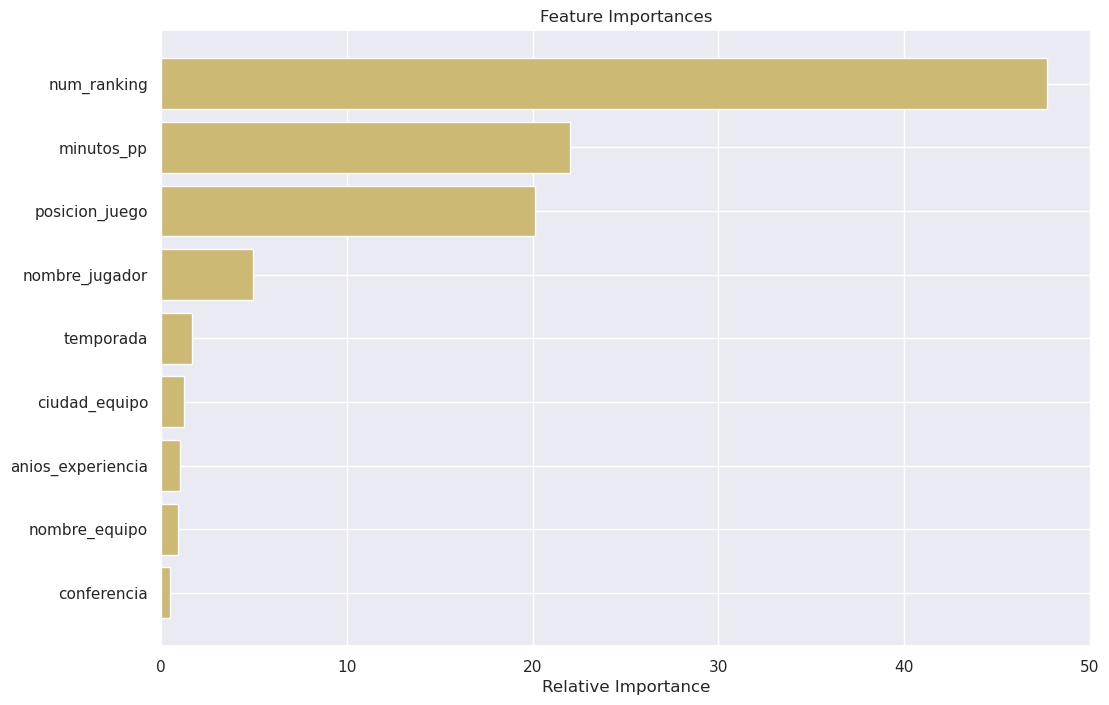

In [212]:
# Se visualiza la importancia de las variables (feature importance) en el modelo CatBoost utilizado

plot_feature_importance(X_1.columns, model_catboost_1.feature_importances_)

Se observa que la posición del jugador influye sobre el PIR medio total del mismo. Puede ser interesante transformar esta feature categórica a numérica de cara a mejorar el modelo.


Por otro lado, el resto de features categóricas no parecen ser realmente significativas sobre el target (*pir_medio_total*).

__________________________________________________________________________________________________________________

### 3.2.3. Modelo de Regresión Lineal

In [213]:
# Se hace una copia del conjunto Train

df_train_copy_2 = df_train_copy.copy()

In [214]:
# Se divide de nuevo el conjunto Train

X_2 = df_train_copy_2.drop(columns = ["pir_medio_total", 'temporada','nombre_jugador','posicion_juego',
                                  'ciudad_equipo','nombre_equipo', 'conferencia'])

y_2 = df_train_copy_2["pir_medio_total"]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,
                                                            y_2,
                                                            test_size = 0.2,
                                                            random_state = 24)

In [215]:
# Se crea el modelo

model_regression_2 = LinearRegression()

In [216]:
# Se entrena el modelo

model_regression_2.fit(X_train_2, y_train_2)

LinearRegression()

In [217]:
model_regression_2.intercept_

7.130321114522041

In [218]:
model_regression_2.coef_

array([-0.01972682,  0.19463296,  0.04657881])

In [219]:
coef_df_2 = pd.DataFrame(model_regression_2.coef_, X_2.columns,
                         columns = ['Coefficient'])

coef_df_2

,Coefficient
num_ranking,-0.019727
minutos_pp,0.194633
anios_experiencia,0.046579


In [220]:
# Se hacen las predicciones en el conjunto Test

pred_test_2 = model_regression_2.predict(X_test_2)
pred_test_2

array([-9.74539200e-01,  5.01896025e+00,  2.04732595e+00,  1.63805958e+00,
        1.93569452e-01,  1.09520191e+01,  3.28963251e+00,  3.29248711e+00,
        1.10545485e+01,  2.90810988e+00,  5.15526081e+00,  1.12716787e+01,
        4.97297608e+00,  8.11789813e+00,  6.53825628e+00,  1.04269898e+01,
        5.71006108e+00,  9.24818165e+00,  9.57436168e+00,  5.39837471e+00,
        1.04730890e+01,  8.11638195e-01,  5.05128870e+00,  9.46083522e+00,
        3.31260253e+00,  9.16314580e+00,  5.43606141e+00,  3.82669917e+00,
        1.96635465e+00,  1.35705607e+01,  8.56768925e+00,  5.97652350e+00,
        1.07974243e+01,  1.07867584e+01,  8.05600152e+00,  8.75204490e+00,
        7.60549759e+00,  1.25158668e+01,  1.44721968e+01,  4.61758310e-01,
        5.29732157e+00,  1.26911615e+01,  1.25980581e+01,  5.62573808e+00,
        7.28385167e+00,  9.09367792e+00,  4.94189439e+00,  9.66621181e+00,
        2.26483787e+00,  6.37287735e+00,  7.58985879e+00,  1.20490889e+01,
        5.48845104e+00,  

In [77]:
# Se calcula el error en el conjunsto Train

pred_train_2 = model_regression_2.predict(X_train_2)

print('MAE', metrics.mean_absolute_error(y_train_2, pred_train_2))
print('MSE', metrics.mean_squared_error(y_train_2, pred_train_2))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_train_2, pred_train_2)))
print('R2', model_regression_2.score(X_train_2, y_train_2))

MAE 2.4654427119096205
MSE 10.779536449745843
RMSE 3.283220438798748
R2 0.6343927534886273


In [78]:
# Se calcula el error en el conjunsto Test

print('MAE', metrics.mean_absolute_error(y_test_2, pred_test_2))
print('MSE', metrics.mean_squared_error(y_test_2, pred_test_2))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test_2, pred_test_2)))
print('R2', model_regression_2.score(X_test_2, y_test_2))

MAE 2.406061518098251
MSE 10.010934893774477
RMSE 3.164006146292146
R2 0.6016895192641031


Probando un **modelo de Regresión Lineal**, se ve que el MAE empeora con respecto al modelo anterior (*el modelo CatBoost*). Tampoco se obtiene un un R2 muy bueno.

__________________________________________________________________________________________________________________

### 3.2.4. Modelo GradientBoostingRegressor

In [79]:
# Se hace una copia del conjunto Train

df_train_copy_3 = df_train_copy.copy()

In [81]:
# Se divide de nuevo el conjunto Train

X_3 = df_train_copy_3.drop(columns = ["pir_medio_total", 'temporada','nombre_jugador','posicion_juego',
                                      'ciudad_equipo','nombre_equipo', 'conferencia'])

y_3 = df_train_copy_3["pir_medio_total"]

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3,
                                                            y_3,
                                                            test_size = 0.2,
                                                            random_state = 24)

In [82]:
model_tree_3 = GradientBoostingRegressor()

model_tree_3.fit(X_train_3, y_train_3)

pred_test_3 = model_tree_3.predict(X_test_3)

In [83]:
# Se calcula el error en el conjunsto Train

pred_train_3 = model_tree_3.predict(X_train_3)

print('MAE', metrics.mean_absolute_error(y_train_3, pred_train_3))
print('MSE', metrics.mean_squared_error(y_train_3, pred_train_3))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_train_3, pred_train_3)))
print('R2', model_tree_3.score(X_train_3, y_train_3))

MAE 2.0197019376660372
MSE 7.225360814585106
RMSE 2.6880031277111835
R2 0.7549389730451801


In [84]:
# Se calcula el error en el conjunsto Test

print('MAE', metrics.mean_absolute_error(y_test_3, pred_test_3))
print('MSE', metrics.mean_squared_error(y_test_3, pred_test_3))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test_3, pred_test_3)))
print('R2', model_tree_3.score(X_test_3, y_test_3))

MAE 2.14989639610768
MSE 8.073835481993223
RMSE 2.8414495388785674
R2 0.6787619411834216


En un **modelo de GradientBoostingRegressor**, se ve que el MAE mejora con respecto al modelo CatBoost y el de Regresión Lineal. 


De hecho, sobre el conjunto Test el R2 es de 1.0. Es decir, que predice todos los valores a la perfección.

##### Se transforma la variable categórica 'posicion' a numérica y se prueba de nuevo de modelo definido anteriormente

In [89]:
# Se hace una copia del conjunto Train

df_train_copy_4 = df_train_copy.copy()

In [130]:
# Se transforma la variable 'posicion' de categórica a numérica haciendo un 'Ordinal Encoding'

posicion_dict = {'Base': 0,
                 'Alero': 1, 
                 'Ala-Pivot': 2, 
                 'Pivot': 3, 
                 'Escolta-Alero': 4, 
                 'Ala-Escolta': 5 
                }


df_train_copy_4['posicion_juego'] = df_train_copy_4.posicion_juego.replace(posicion_dict)
df_train_copy_4

,temporada,nombre_jugador,num_ranking,ciudad_equipo,nombre_equipo,conferencia,minutos_pp,posicion_juego,pir_medio_total,anios_experiencia
3785,2019-2020,Kyle Korver,275,Milwaukee,Bucks,Eastern,16.6,4,3.05,16.0
4363,2020-2021,Josh Hall,389,Oklahoma City,Thunder,Western,16.0,1,-0.38,0.0
2888,2017-2018,C.J. Williams,324,LA,Clippers,Western,18.6,5,2.63,5.0
1632,2014-2015,Steve Blake,351,Portland,Trail Blazers,Western,18.9,0,2.93,11.0
854,2012-2013,Jarvis Varnado,460,Boston,Celtics,Eastern,4.5,2,0.08,0.0
...,...,...,...,...,...,...,...,...,...,...
4859,2021-2022,Malcolm Hill,403,Chicago,Bulls,Eastern,11.2,1,2.32,4.0
3264,2018-2019,Langston Galloway,213,Detroit,Pistons,Eastern,21.8,0,2.44,4.0
1653,2014-2015,Joffrey Lauvergne,372,Denver,Nuggets,Western,11.2,2,2.46,1.0
2607,2017-2018,Evan Fournier,40,Orlando,Magic,Eastern,32.2,4,9.11,5.0


In [93]:
# Se divide de nuevo el conjunto Train

X_4 = df_train_copy_4.drop(columns = ["pir_medio_total", 'temporada','nombre_jugador',
                                      'ciudad_equipo','nombre_equipo', 'conferencia'])

y_4 = df_train_copy_4["pir_medio_total"]

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4,
                                                            y_4,
                                                            test_size = 0.2,
                                                            random_state = 24)

In [94]:
# Se entrena el modelo

model_tree_4 = GradientBoostingRegressor()

model_tree_4.fit(X_train_4, y_train_4)

GradientBoostingRegressor()

In [95]:
# Se calcula el error en el conjunsto Train

pred_train_4 = model_tree_4.predict(X_train_4)

print('MAE', metrics.mean_absolute_error(y_train_4, pred_train_4))
print('MSE', metrics.mean_squared_error(y_train_4, pred_train_4))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_train_4, pred_train_4)))
print('R2', model_tree_4.score(X_train_4, y_train_4))

MAE 1.5819374780315887
MSE 4.398791220455322
RMSE 2.0973295450298988
R2 0.8508071331650826


In [96]:
# Se calcula el error en el conjunsto Test

pred_test_4 = model_tree_4.predict(X_test_4)

print('MAE', metrics.mean_absolute_error(y_test_4, pred_test_4))
print('MSE', metrics.mean_squared_error(y_test_4, pred_test_4))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test_4, pred_test_4)))
print('R2', model_tree_4.score(X_test_4, y_test_4))

MAE 1.7140029994155603
MSE 5.25571726775689
RMSE 2.2925351181076574
R2 0.7908879346689155


Se prueba de nuevo un **modelo de GradientBoostingRegressor** tras haber transformado la variable *posicion* a numérica a través de un Ordinal Encoding.

Se observa que el rendimiento del modelo mejora en Train y que el conjunto Test se mantiene el R2 de 1.0.

### Se prueba en el conjunto Test

In [98]:
# Se aplican todos los cambios realizados en el conjunto Train sobre el Test

# Se transforma la variable 'posicion_juego' de categórica a numérica haciendo un 'Ordinal Encoding'

df_test['posicion_juego'] = df_test.posicion_juego.replace(posicion_dict)


X_test_final = df_test.drop(columns = ['asistencias_total', 'tapones_total', 'tce_total', 'tle_total', 'tte_total',
                                       'puntos_total', 'rebotes_total', 'robos_total', 'tci_total', 'tli_total',
                                       'tti_total', 'perdidas_total', 'faltas_total', 'faltas_tecnicas_total',
                                       'tci_pp', 'tce_pp', 'porcentaje_tc_pp', 'tli_pp', 'tle_pp', 
                                       'porcentaje_tl_pp', 'total_rebotes_pp', 'faltas_pp','robos_pp', 
                                       'perdidas_pp', 'eficiencia_tiro_total', 'porcentaje_tc_total',
                                       'porcentaje_tl_total', 'porcentaje_tt_total', 'reb_def_total', 
                                       'reb_of_total', 'temporada','nombre_jugador', 'ciudad_equipo', 
                                       'nombre_equipo', 'conferencia', 'partidos_jugados', 'asistencias_pp', 
                                       'tapones_pp', 'eficiencia_tiro_pp', 'tti_pp', 'tte_pp', 'porcentaje_tt_pp',
                                       'puntos_pp', 'reb_def_pp', 'reb_of_pp', "pir_medio_total",
                                       'altura', 'peso_kg', 'anio', 'id_jugador', 'draft_anio', 'minutos_total'])


y_test_final = df_test["pir_medio_total"]

In [99]:
# Se calcula el error en el conjunsto Test

pred_test_final = model_tree_4.predict(X_test_final)

print('MAE', metrics.mean_absolute_error(y_test_final, pred_test_final))
print('MSE', metrics.mean_squared_error(y_test_final, pred_test_final))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test_final, pred_test_final)))
print('R2', model_tree_4.score(X_test_final, y_test_final))

MAE 1.6718188797858509
MSE 4.899932529617405
RMSE 2.2135791220594316
R2 0.8257497574073496


## 3.4. Se guarda el modelo

In [128]:
with open('/home/inma/Escritorio/The Bridge/Data_Science_Curso/Clase/Repository_Inma/ML/ML_NBA_Inma Jimenez/scr/notebooks/Model_Test/model_noparams_finished.model', 'wb') as file:
    pickle.dump(model_tree_4, file) 

## Para abrir el modelo

In [70]:
with open('model_noparams_finished.model', 'rb') as file: # Usar 'rb' porque 'r' da un error
    logisticRegr = pickle.load(file)

__________________________________________________________________________________________________________________

## 4. Hiperparametrización

### 4.1. RandomSearch

In [102]:
# Se hace una copia del conjunto Train

df_train_copy_5 = df_train_copy.copy()

In [129]:
# Se transforma la variable 'posicion_juego' de categórica a numérica haciendo un 'Ordinal Encoding'

df_train_copy_5['posicion_juego'] = df_train_copy_5.posicion_juego.replace(posicion_dict)


# Se divide de nuevo el conjunto Train

X_5 = df_train_copy_5.drop(columns = ["pir_medio_total", 'temporada','nombre_jugador',
                                      'ciudad_equipo','nombre_equipo', 'conferencia'])

y_5 = df_train_copy_5["pir_medio_total"]

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5,
                                                            y_5,
                                                            test_size = 0.2,
                                                            random_state = 24)

In [104]:
# Se aplica un RandomSearch sobre el modelo de GradientBoostingRegressor

param_grid = {'alpha': [1e-10, 1e-4, 1e-2, 1, 5, 10, 20, 40]}


# Se crea el modelo de GradientBoostingRegressor con estos parámetros
gb_model_5 = GradientBoostingRegressor()

random_search = RandomizedSearchCV(gb_model_5, 
                                   param_grid,
                                   random_state = 1,
                                   n_iter = 100, 
                                   cv = 5, 
                                   scoring = 'r2', 
                                   n_jobs = -1
                                  )

random_search.fit(X_train_5, y_train_5)

/home/inma/.conda/envs/general/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/inma/.conda/envs/general/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/inma/.conda/envs/general/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/inma/.co

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'alpha': [1e-10, 0.0001, 0.01, 1, 5, 10,
                                                  20, 40]},
                   random_state=1, scoring='r2')

In [105]:
# Mejores Hiperparámetros del modelo

random_search.best_params_

# El mejor modelo lo ha encontrado con alpha = 0.0001

{'alpha': 0.0001}

In [106]:
# Mejor score (R2) - Este es el score del Cross Validation

random_search.best_score_

0.8170240479986409

In [107]:
# Se crea el modelo con los best params obtenidos

model_random_final = GradientBoostingRegressor(alpha = 0.01)

### Se prueba en el conjunto Test

In [109]:
# Se aplican todos los cambios realizados en el conjunto Train sobre el Test

# Se transforma la variable 'posicion' de categórica a numérica haciendo un 'Ordinal Encoding'

df_test_copy_5 = df_test.copy()

df_test_copy_5['posicion_juego'] = df_test_copy_5.posicion_juego.replace(posicion_dict)

X_test_final_5 = df_test_copy_5.drop(columns = ["pir_medio_total", 'temporada','nombre_jugador',
                                                'ciudad_equipo','nombre_equipo', 'conferencia'])


y_test_final_5 = df_test_copy_5["pir_medio_total"]

In [110]:
model_random_final.fit(X_test_final_5, y_test_final_5)

GradientBoostingRegressor(alpha=0.01)

In [111]:
pred_test_final_5 = model_random_final.predict(X_test_final_5)

print('MAE: ', metrics.mean_absolute_error(y_test_final_5, pred_test_final_5))
print('MSE: ', metrics.mean_squared_error(y_test_final_5, pred_test_final_5))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test_final_5, pred_test_final_5)))
print('R2: ', model_random_final.score(X_test_final_5, y_test_final_5))

MAE:  0.20413916709167093
MSE:  0.06615279270765126
RMSE:  0.25720185206885904
R2:  0.9976474900199515


### 4.2. GridSearch. Modelo Definitivo

In [118]:
# Se hace una copia del conjunto Train

df_train_copy_6 = df_train_copy.copy()

# Se transforma la variable 'posicion' de categórica a numérica haciendo un 'Ordinal Encoding'

df_train_copy_6['posicion_juego'] = df_train_copy_6.posicion_juego.replace(posicion_dict)

# Se divide de nuevo el conjunto Train

X_6 = df_train_copy_6.drop(columns = ["pir_medio_total", 'temporada','nombre_jugador',
                                      'ciudad_equipo','nombre_equipo', 'conferencia'])

y_6 = df_train_copy_6["pir_medio_total"]

X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_6,
                                                            y_6,
                                                            test_size = 0.2,
                                                            random_state = 24)

In [119]:
# Se aplica un GridSearch sobre el modelo de GradientBoostingRegressor

param_grid = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
              'max_depth'    : [4,6,8,10]
             }

gb_model_6 = GradientBoostingRegressor()

grid_search = GridSearchCV(gb_model_6,
                           param_grid,
                           cv=5, 
                           scoring = 'r2',
                           n_jobs = -1
                          )


grid_search.fit(X_train_6, y_train_6)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [100, 500, 1000, 1500],
                         'subsample': [0.9, 0.5, 0.2, 0.1]},
             scoring='r2')

In [120]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.9}

In [121]:
grid_search.best_score_

0.820774090646727

In [122]:
grid_search.best_estimator_.score(X_test_6, y_test_6)

0.794366115107816

In [123]:
# Se crea el modelo con los best params obtenidos

model_grid_final = GradientBoostingRegressor(learning_rate = 0.04, 
                                             max_depth = 4, 
                                             n_estimators = 1500, 
                                             subsample = 0.2
                                            )

### Se prueba en el conjunto Test

In [124]:
# Se aplican todos los cambios realizados en el conjunto Train sobre el Test

# Se transforma la variable 'posicion' de categórica a numérica haciendo un 'Ordinal Encoding'

df_test_copy_6 = df_test.copy()

df_test_copy_6['posicion_juego'] = df_test_copy_6.posicion_juego.replace(posicion_dict)

X_test_final_6 = df_test_copy_6.drop(columns = ["pir_medio_total", 'temporada','nombre_jugador',
                                                'ciudad_equipo','nombre_equipo', 'conferencia'])


y_test_final_6 = df_test_copy_6["pir_medio_total"]

In [125]:
model_grid_final.fit(X_test_final_6, y_test_final_6)

GradientBoostingRegressor(learning_rate=0.04, max_depth=4, n_estimators=1500,
                          subsample=0.2)

In [126]:
pred_test_final_6 = model_grid_final.predict(X_test_final_6)

print('MAE: ', metrics.mean_absolute_error(y_test_final_6, pred_test_final_6))
print('MSE: ', metrics.mean_squared_error(y_test_final_6, pred_test_final_6))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test_final_6, pred_test_final_6)))
print('R2: ', model_grid_final.score(X_test_final_6, y_test_final_6))

MAE:  0.022438331178958066
MSE:  0.0007381872141664206
RMSE:  0.027169600920264186
R2:  0.9999737487607493


## 4.3. Se guarda el modelo

In [127]:
with open('/home/inma/Escritorio/The Bridge/Data_Science_Curso/Clase/Repository_Inma/ML/ML_NBA_Inma Jimenez/scr/model_withparams_finished.model', 'wb') as file:
    pickle.dump(model_grid_final, file)

## Para abrir el modelo

In [ ]:
with open('model_withparams_finished.model', 'rb') as file: # Usar 'rb' porque 'r' da un error
    logisticRegr = pickle.load(file)